# Machine Learning with ODC <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)
* **Special requirements:** A shapefile of labelled data is required to use this notebook
* **Prerequisites:** A basic understanding of supervised learning techniques is required. [Introduction to statistical learning](https://doi.org/10.1007/978-1-4614-7138-7) is a useful resource to begin with. The [Scikit-learn](https://scikit-learn.org/stable/supervised_learning.html) documentation provides information on the available models and their parameters.


## Description

This notebook demonstrates a potential workflow using _dea_classificationtools_ to implement a supervised learning landcover classifier within the ODC framework. 

This example predicts a single class of cultivated / agricultural area.

The model training process is one of experimentation and assumption checking that occurs in an iterative cycle. 

For larger model training and prediction implementations this notebook can be adapted into a python file and run in a distributed fashion.

>**Before using this notebook for your own purposes you must have labelled data in the shapefile format. An example dataset is provided.**

1. Extract the desired ODC data for each labelled area (This becomes our training dataset).
2. Train a model, adjust parameters. 
3. Predict landcover using trained model on new data

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
import seaborn as sns
import os
import pickle
import numpy
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
from datacube.utils import geometry
from datacube import helpers

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_classificationtools import get_training_data_for_shp, predict_xr

/home/jovyan/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [2]:
dc = datacube.Datacube(app='Machine_learning_with_ODC')

### Analysis parameters
* `path`: The path to the input shapefile
* `field`: This is the name of column in your shapefile attribute table that contains the class labels
* `product`: The name of the product to extract. This method works on DEA Landsat Collection 3 ARD Landsat 7 and Landsat 8 data - [ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)
 is a good start.
* `year`: The year you wish to extract data for, typically the same year the labels were created
* `feature stats`: This is an option to calculate the mean of the values within the feature, it is useful for reducing noise and simplifying you

In [3]:
path = '../Supplementary_data/Machine_learning_with_ODC/Cell_-16_-39_2015.shp'
field = 'classnum'
product = 'ls8_nbart_geomedian_annual'
year = 2015
feature_stats = 'mean'

## Extract training data using a shapefile

This function takes a shapefile that contains class labels and extracts the specified product within these areas into a single array

> The following cell can take several minutes to run

> The class labels will be contained in the first column of the output array

In [4]:
# Empty list which we will populate with data
out = []

# Calling the extraction function
column_names = get_training_data_for_shp(path, out,
                                         product=product,
                                         time=('{}-01-01'.format(year),
                                               '{}-12-31'.format(year)),
                                         crs='EPSG:3577', field=field,
                                         calc_indices=None,
                                         feature_stats=feature_stats)

# Stacking the extracted training data for each feature into a single array
model_input = np.vstack(out)
print(model_input.shape)

Loading data...
Rasterizing features and extracting data...
(217, 7) 0217/0217


## Preprocessing

In [5]:
# Remove any potential nans
model_input = model_input[~numpy.isnan(model_input).any(axis=1)]
print("Cleaned input shape:", model_input.shape)

Cleaned input shape: (217, 7)


In [6]:
# Modify the input training data for single class labels
model_input[:,0] = np.where(model_input[:,0] == 111, 1, 0)

Split data into training and testing data.
80 % is used for training with 20 % held back for testing.
Use class to provide similar distribution across classes under the 'stratify' parameter in training and testing data

In [7]:
# Split into training and testing data
model_train, model_test = model_selection.train_test_split(model_input, stratify=model_input[:, 0],
                                                           train_size=0.8, random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)


Train shape: (173, 7)
Test shape: (44, 7)


## Model preparation

In [8]:
# Extract the variable names and relevant indices from the processed shapefile
model_variables = column_names[1:]

column_names_indices = {}

for col_num, var_name in enumerate(column_names):
    column_names_indices[var_name] = col_num

model_col_indices = []

for model_var in model_variables:
    model_col_indices.append(column_names_indices[model_var])
    
print(column_names_indices)

{'classnum': 0, 'blue': 1, 'green': 2, 'red': 3, 'nir': 4, 'swir1': 5, 'swir2': 6}


In [9]:
# Initialise model
model = tree.DecisionTreeClassifier()

## Train model

In [10]:
# Train model
model.fit(model_train[:,model_col_indices], model_train[:,0])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

# Analyse results

The decision tree classifier allows us to inspect the feature importance of each input covariate and also plot the decision tree formulated to predicted the landcover class

In [11]:
# This shows the feature importance of the input features for predicting the class labels provided
print(dict(zip(model_variables, model.feature_importances_)))

{'blue': 0.0, 'green': 0.21553469423351249, 'red': 0.0, 'nir': 0.0, 'swir1': 0.7844653057664875, 'swir2': 0.0}


In [12]:
# Prepare a dictionary of class names
class_names = {1: 'Cultivated Terrestrial Vegetated', 0: 'Not Cultivated Terrestrial Vegetated'}

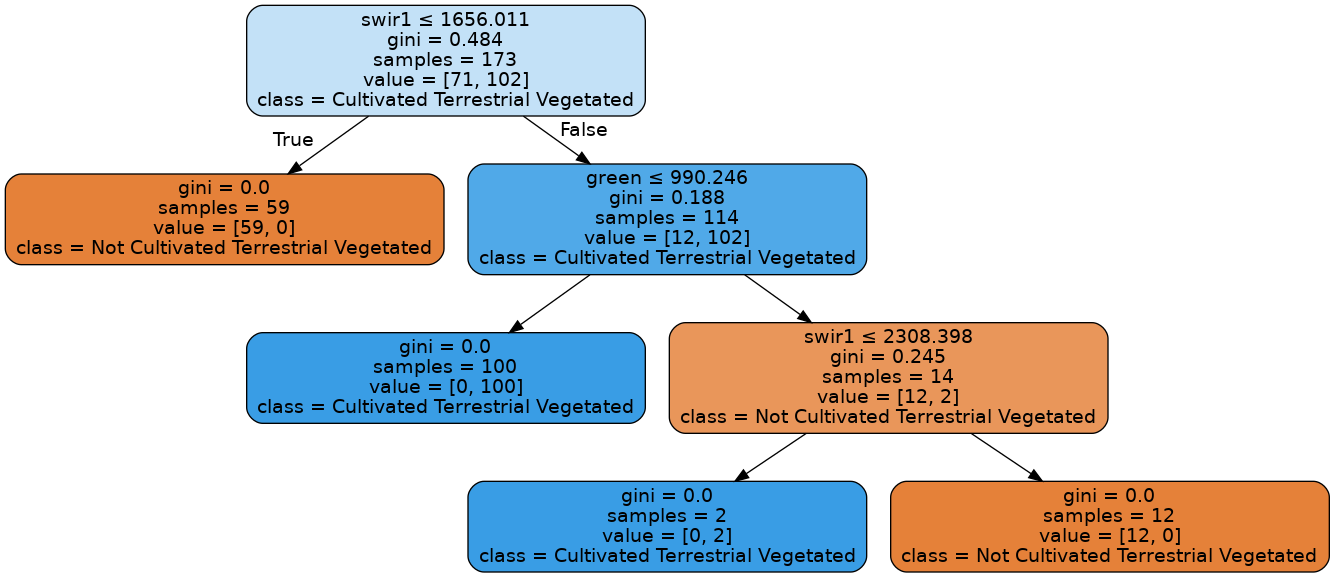

In [13]:
# Plot decision tree
class_codes = numpy.unique(model_train[:,0])

class_names_in_model = list({k: class_names[k] for k in class_codes}.values())

dot_data = StringIO()

tree.export_graphviz(model, out_file=dot_data, feature_names = model_variables, class_names=class_names_in_model,
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Prediction

Load new data and use the `predict_xr` function to predict the landcover class using the trained model

In [18]:
# Set up the query parameters
query = {'time': ('{}-01-01'.format(year), '{}-12-31'.format(year))}
query['x'] = (-1559125, -1500000)
query['y'] = (-3851325, -3800000)
query['crs'] = 'EPSG:3577'
query['resolution'] = (-25, 25)

In [19]:
# Load new input data, remember the product must match the product that the model was trained on
geomedian_data = dc.load(product='ls8_nbart_geomedian_annual', group_by='solar_day', **query)

In [27]:
# Predict landcover using the trained model
predicted = predict_xr(model, geomedian_data, progress=True)

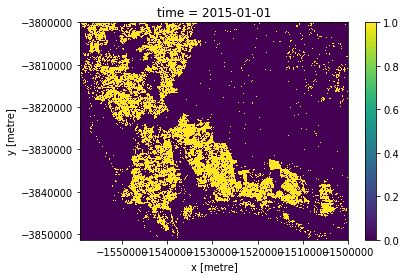

In [28]:
# Plot the predicted extent of the landcover class
predicted.plot()

In [29]:
# 
predicted = predicted.to_dataset(name="predicted")
predicted.attrs['crs']=geometry.CRS("EPSG:3577")
predicted = predicted.isel(time=0)
predicted.attrs['crs']=geometry.CRS("EPSG:3577")
helpers.write_geotiff('predicted.tif', predicted)

In [ ]:
predicted

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [22]:
print(datacube.__version__)

1.7+164.gbdf45994.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)